In [32]:
import tensorflow as tf
from tensorflow.python.keras.engine.base_layer import Layer
from math import sqrt
import math
import numpy as np
from tensorflow.keras.layers import LeakyReLU
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras import layers
from Energy_Models import Models as mo
from Data import preprocess_data as pr

In [11]:
df = pd.read_csv('D:\College\Final\Gpr\Datasets\household_power_consumption.txt',sep=';', 
                 parse_dates={'date_time' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='date_time')

In [12]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
date_time,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [14]:
df.shape

(2075259, 7)

In [15]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [16]:
# filling missing values by the value of one day before 
def fill_missing(data):
    one_day = 24*60
    for row in range(data.shape[0]):
        for col in range(data.shape[1]):
            if np.isnan(data[row,col]):
                data[row,col] = data[row-one_day,col]

In [17]:
fill_missing(df.values)

In [18]:
df.to_csv('D:\College\Final\Gpr\Datasets\household_power_consumption.csv')
#index >> date-time
df = pd.read_csv('D:\College\Final\Gpr\Datasets\household_power_consumption.csv',parse_dates=['date_time'], index_col= 'date_time')

In [19]:
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [20]:
# Compute remaining active power
df['sub_metering_remaining'] = (df.Global_active_power * 1000  / 60 ) - (df.Sub_metering_1 + df.Sub_metering_2 + df.Sub_metering_3)

In [21]:
# descriptive statistics
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_remaining
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.089418e+00,1.236871e-01,2.408364e+02,4.618401e+00,1.118474e+00,1.291131e+00,6.448635e+00,9.298722e+00
std,1.054678e+00,1.125933e-01,3.240051e+00,4.433165e+00,6.141460e+00,5.796922e+00,8.433584e+00,9.561278e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.800000e+00
50%,6.020000e-01,1.000000e-01,2.410000e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.500000e+00
75%,1.526000e+00,1.940000e-01,2.428700e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.036667e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


In [22]:
# resample the data on daily basis
df = df.resample('D').mean()
df.shape

(1442, 8)

In [23]:
def train_test_split(df):
    
    # compute split point
    end_idx = df.shape[0]* 70 // 100
    
    train_data = df.iloc[:end_idx, : ]
    test_data = df.iloc[end_idx:, :]
    
    return train_data, test_data

In [39]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [40]:
from sklearn.preprocessing import MinMaxScaler
def scale_data(train, test):
    scaler = MinMaxScaler().fit(train)
    return scaler.transform(train), scaler.transform(test), scaler

In [41]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [42]:
# Split the training data into input features and out feature
X_train, Y_train = pr.convert_UNI_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (1008, 1, 7) and ouput feature (1008,)


In [43]:
# Split the testing data into input features and out feature
X_test, Y_test = pr.convert_UNI_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (432, 1, 7) and ouput feature (432,)


In [108]:
n_steps, n_features = X_train.shape[1], X_train.shape[2]
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

In [76]:
model = mo.lstm(n_steps,n_features,1).getModel()
model.compile(optimizer='adam', loss ='mae')
history = model.fit(X_train , Y_train, epochs=200, batch_size=128, verbose= 1,validation_split=0.3)

Epoch 1/200
6/6 [==============================] - 3s 72ms/step - loss: 0.2808 - val_loss: 0.2462
Epoch 2/200
6/6 [==============================] - 0s 9ms/step - loss: 0.2450 - val_loss: 0.2042
Epoch 3/200
6/6 [==============================] - 0s 11ms/step - loss: 0.2044 - val_loss: 0.1582
Epoch 4/200
6/6 [==============================] - 0s 9ms/step - loss: 0.1587 - val_loss: 0.1118
Epoch 5/200
6/6 [==============================] - 0s 8ms/step - loss: 0.1215 - val_loss: 0.0938
Epoch 6/200
6/6 [==============================] - 0s 11ms/step - loss: 0.1136 - val_loss: 0.1097
Epoch 7/200
6/6 [==============================] - 0s 12ms/step - loss: 0.1147 - val_loss: 0.0964
Epoch 8/200
6/6 [==============================] - 0s 11ms/step - loss: 0.1091 - val_loss: 0.0917
Epoch 9/200
6/6 [==============================] - 0s 12ms/step - loss: 0.1085 - val_loss: 0.0908
Epoch 10/200
6/6 [==============================] - 0s 11ms/step - loss: 0.1076 - val_loss: 0.0899
Epoch 11/200
6/6 [====

6/6 [==============================] - 0s 7ms/step - loss: 0.0767 - val_loss: 0.0675
Epoch 85/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0770 - val_loss: 0.0676
Epoch 86/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0762 - val_loss: 0.0679
Epoch 87/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0761 - val_loss: 0.0675
Epoch 88/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0763 - val_loss: 0.0673
Epoch 89/200
6/6 [==============================] - 0s 10ms/step - loss: 0.0755 - val_loss: 0.0674
Epoch 90/200
6/6 [==============================] - 0s 6ms/step - loss: 0.0761 - val_loss: 0.0673
Epoch 91/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0771 - val_loss: 0.0678
Epoch 92/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0764 - val_loss: 0.0665
Epoch 93/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0756 - val_loss: 0.0671
Epoch 94/200
6/6 [============

Epoch 167/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0734 - val_loss: 0.0670
Epoch 168/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0738 - val_loss: 0.0666
Epoch 169/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0731 - val_loss: 0.0668
Epoch 170/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0729 - val_loss: 0.0673
Epoch 171/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0720 - val_loss: 0.0667
Epoch 172/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0729 - val_loss: 0.0659
Epoch 173/200
6/6 [==============================] - 0s 9ms/step - loss: 0.0734 - val_loss: 0.0685
Epoch 174/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0740 - val_loss: 0.0666
Epoch 175/200
6/6 [==============================] - 0s 8ms/step - loss: 0.0743 - val_loss: 0.0690
Epoch 176/200
6/6 [==============================] - 0s 11ms/step - loss: 0.0732 - val_loss: 0.0660
Epoch 1

In [77]:
mo.evaluate(model,X_train, Y_train)
mo.evaluate(model,X_test, Y_test)

32/32 [==============================] - 0s 2ms/step - loss: 0.0704
evaluation : 0.070 
14/14 [==============================] - 0s 2ms/step - loss: 0.0620
evaluation : 0.062 


In [78]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

14/14 [==============================] - 0s 2ms/step


In [79]:
mo.print_metrics(model,Y_train,y_pred_train,Y_test,y_pred_test)

Train RMSE value   : 0.097 
Train MSE value    : 0.009 
Train R2 value     : 0.535 
Train MAPE value   : 46690276433.653 
Train RMLSE value  : 0.005 
Train MAE value    : 0.070 
---------------------------------------------
Test RMSE value   : 0.082 
Test MSE value   : 0.007 
Test R2 value   : 0.395 
Test MAPE value  : 0.251 
Test RMLSE value  : 0.004 
Test MAE value : 0.062 


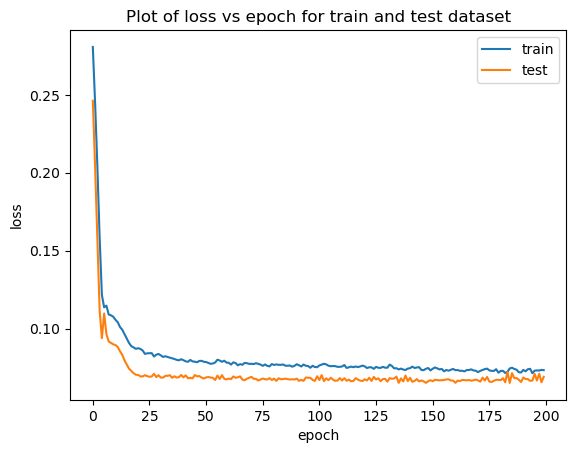

In [80]:
import matplotlib.pyplot as plt 
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [81]:
# Split the data into train and test
X_train, X_test = train_test_split(df)

In [82]:
# Scale the data
X_train, X_test, scaler = scale_data(X_train, X_test)

In [86]:
# Split the training data into input features and out feature
X_train, Y_train = pr.convert_Multi_to_supervised(X_train)
print('Shape of (training data) input features : %s and ouput feature %s' % (X_train.shape, Y_train.shape))

Shape of (training data) input features : (982, 21, 7) and ouput feature (982, 7)


In [87]:
X_test, Y_test = pr.convert_Multi_to_supervised(X_test)
print('Shape of (testing data) input features : %s and ouput feature %s' % (X_test.shape, Y_test.shape))

Shape of (testing data) input features : (406, 21, 7) and ouput feature (406, 7)


In [176]:
n_steps, n_features = X_train.shape[1], X_train.shape[2]
model = mo.lstm(n_steps,n_features,7).getModel()
model.compile(optimizer='adam', loss ='mse')
history = model.fit(X_train , Y_train, epochs=200, batch_size=128, verbose= 1,validation_split=0.2,callbacks=callback)

Epoch 1/200
7/7 [==============================] - 3s 114ms/step - loss: 0.0883 - val_loss: 0.0151
Epoch 2/200
7/7 [==============================] - 1s 75ms/step - loss: 0.0301 - val_loss: 0.0094
Epoch 3/200
7/7 [==============================] - 1s 76ms/step - loss: 0.0235 - val_loss: 0.0126
Epoch 4/200
7/7 [==============================] - 0s 59ms/step - loss: 0.0191 - val_loss: 0.0104
Epoch 5/200
7/7 [==============================] - 0s 61ms/step - loss: 0.0179 - val_loss: 0.0089
Epoch 6/200
7/7 [==============================] - 0s 61ms/step - loss: 0.0172 - val_loss: 0.0106
Epoch 7/200
7/7 [==============================] - 0s 61ms/step - loss: 0.0166 - val_loss: 0.0071
Epoch 8/200
7/7 [==============================] - 0s 60ms/step - loss: 0.0163 - val_loss: 0.0093
Epoch 9/200
7/7 [==============================] - 0s 60ms/step - loss: 0.0164 - val_loss: 0.0055
Epoch 10/200
7/7 [==============================] - 0s 61ms/step - loss: 0.0160 - val_loss: 0.0063
Epoch 11/200
7/7 [

Epoch 84/200
7/7 [==============================] - 0s 62ms/step - loss: 0.0114 - val_loss: 0.0144
Epoch 85/200
7/7 [==============================] - 0s 62ms/step - loss: 0.0116 - val_loss: 0.0149
Epoch 86/200
7/7 [==============================] - 0s 61ms/step - loss: 0.0118 - val_loss: 0.0139
Epoch 87/200
7/7 [==============================] - 0s 62ms/step - loss: 0.0114 - val_loss: 0.0133
Epoch 88/200
7/7 [==============================] - 0s 62ms/step - loss: 0.0115 - val_loss: 0.0139
Epoch 89/200
7/7 [==============================] - 0s 62ms/step - loss: 0.0115 - val_loss: 0.0129
Epoch 90/200
7/7 [==============================] - 0s 63ms/step - loss: 0.0112 - val_loss: 0.0146
Epoch 91/200
7/7 [==============================] - 0s 60ms/step - loss: 0.0110 - val_loss: 0.0133
Epoch 92/200
7/7 [==============================] - 0s 61ms/step - loss: 0.0110 - val_loss: 0.0136
Epoch 93/200
7/7 [==============================] - 0s 63ms/step - loss: 0.0108 - val_loss: 0.0139
Epoch 94/2

In [177]:
mo.evaluate(model,X_train, Y_train)
mo.evaluate(model,X_test, Y_test)

31/31 [==============================] - 0s 9ms/step - loss: 0.0095
evaluation : 0.009 
13/13 [==============================] - 0s 9ms/step - loss: 0.0094
evaluation : 0.009 


In [178]:
y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test) 

13/13 [==============================] - 0s 9ms/step


In [179]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error
def root_mean_squared_error(y_true, y_pred):    
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [180]:
def print_metrics(model,Y_train,Y_pred_train,Y_test,Y_pred_test):
    print('Train MAE  value   : %.3f ' % mean_absolute_error(Y_train, Y_pred_train))
    print('Train MSE  value   : %.3f ' % mean_squared_error(Y_train, Y_pred_train))
    print('Train RMSE value   : %.3f ' % root_mean_squared_error(Y_train, Y_pred_train))
    print('Train R2   value   : %.3f ' % r2_score(Y_train, Y_pred_train))
    print('---------------------------------------------')
    print('Test  MAE  value   : %.3f ' % mean_absolute_error(Y_test, Y_pred_test))
    print('Test  MSE  value   : %.3f ' % mean_squared_error(Y_test, Y_pred_test))
    print('Test  RMSE value   : %.3f ' % root_mean_squared_error(Y_test, Y_pred_test))
    print('Test  R2   value   : %.3f ' % r2_score(Y_test, Y_pred_test))
print_metrics(model,Y_train,y_pred_train,Y_test,y_pred_test)

Train MAE  value   : 0.077 
Train MSE  value   : 0.009 
Train RMSE value   : 0.097 
Train R2   value   : 0.496 
---------------------------------------------
Test  MAE  value   : 0.076 
Test  MSE  value   : 0.009 
Test  RMSE value   : 0.097 
Test  R2   value   : 0.179 


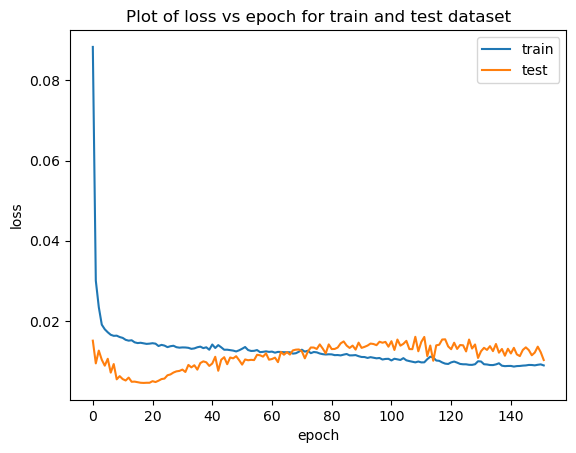

In [181]:
# Plot of loss vs epoch for train and test dataset
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Plot of loss vs epoch for train and test dataset")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()